<h1><center>Algorithms for image reconstruction in Computer Tomography</center></h1>


*The intent of this notebook is to showcase some of the algorithms that are used in computer tomography. **These functions should not be used for any medical purposes.** Since the main purpose of the notebook is to show the algorithms nearly no optimizations will be made.*

*This notebook assumes that the reader has basic knowledge of linear algebra and Fourier transform as they are not covered.*

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Forward-projection-and-image-rotation" data-toc-modified-id="Forward-projection-and-image-rotation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Forward projection and image rotation</a></span></li><li><span><a href="#Analytic-Reconstruction-Algorithms" data-toc-modified-id="Analytic-Reconstruction-Algorithms-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analytic Reconstruction Algorithms</a></span><ul class="toc-item"><li><span><a href="#Back-projection" data-toc-modified-id="Back-projection-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Back projection</a></span><ul class="toc-item"><li><span><a href="#Filtered-back-projection" data-toc-modified-id="Filtered-back-projection-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Filtered back projection</a></span></li></ul></li><li><span><a href="#Projection-slice-theorem-reconstruction" data-toc-modified-id="Projection-slice-theorem-reconstruction-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Projection slice theorem reconstruction</a></span><ul class="toc-item"><li><span><a href="#Adding-a-padding" data-toc-modified-id="Adding-a-padding-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Adding a padding</a></span></li></ul></li></ul></li><li><span><a href="#Iterative-reconstruction-algorithms" data-toc-modified-id="Iterative-reconstruction-algorithms-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Iterative reconstruction algorithms</a></span><ul class="toc-item"><li><span><a href="#Simultaneous-Algebraic-Reconstruction-Technique" data-toc-modified-id="Simultaneous-Algebraic-Reconstruction-Technique-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Simultaneous Algebraic Reconstruction Technique</a></span></li><li><span><a href="#Image-Space-Reconstruction-Algorithm" data-toc-modified-id="Image-Space-Reconstruction-Algorithm-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Image Space Reconstruction Algorithm</a></span></li></ul></li><li><span><a href="#Comparison-and-results" data-toc-modified-id="Comparison-and-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Comparison and results</a></span></li><li><span><a href="#Literature" data-toc-modified-id="Literature-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Literature</a></span></li></ul></div>

In [1]:
# backend
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator

from skimage.data import shepp_logan_phantom
from skimage.transform import rescale

from scipy.fftpack import fft, ifft, fftshift, fft2, ifft2
import scipy.interpolate

In [3]:
# import the visualization functions from v_reconstruction.ipyn
%run -i v_reconstruction.ipynb

In [4]:
# set the default image size and image colourmap
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams['image.cmap'] = 'gray'

## Introduction

Image reconstruction in the field of computer tomography is the computational process that generates volumetric data from X-ray images of a given patient made from different angles. This process has a major impact of the image quality, the spatial resolution and the dose that the patient receives. Reconstruction methods that improve image quality can be translated into a reduction of the irradiated dose, because images of similar quality can be reconstructed at reduced dose. Better knowledge and understanding of the algorithms is essential in order to achieve the delicate balance between patient radiation dose and spacial resolution that is needed for a specific task.  

In this notebook we will examine 4 reconstruction algorithms - two algebraic and two iterative and look at some of the differences and how we can improve them.
In this notebook we will be using the algorithms to reconstruct a plane rather than a volumetric image and we will not be modeling attenuation.


We will be using the Shepp Logan phantom as test image. It was created by Larry Shepp and Benjamin F. Logan for their 1974 paper *The Fourier Reconstruction of a Head Section* .
To get the phantom we will use the `skimage` library and rescale it so the calculations can be faster.

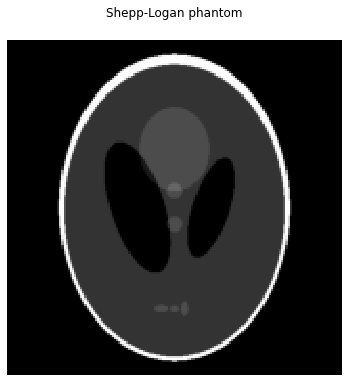

The shape of the phantom is (160, 160)


In [5]:
Shepp_Logan = shepp_logan_phantom()
# we rescale it so it would be faster to work with
Shepp_Logan = rescale(Shepp_Logan, scale=0.4)

plt.matshow(Shepp_Logan)
plt.axis('off')
plt.title("Shepp-Logan phantom")
plt.show()

print("The shape of the phantom is {}".format(Shepp_Logan.shape))

 This is a model of a human head and is often used in the development and testing of image reconstruction algorithms. The image below shows what the different parts are.
 
![](data/img/Shepp-Logan-exp.jpeg)
 

[source: Mohammed H. Ali Al-Hayani](https://www.researchgate.net/figure/Shepp-Logan-head-phantom-image-The-2D-Shepp-Logan-phantom-image-illustrates-many-of-the_fig5_337495686)

When reconstructing the phantom we will be looking at two metrics in order to asses the result - the root mean square error and a line profile that passes through the three tumors.


**RMSE**

The root mean square error is defined by the root of the squared difference between expected and observed values, divided by the number of values.  

$$\large
\mathrm{RMSE} = \sqrt{\frac{\sum \limits^{N,M}_{i,j=1}\left(f(i,j)-f'(i,j)\right)^2}{N*M}}
$$

In our case $f(i,j)$ is the Shepp-Logan phantom and $f'(i,j)$ will be the computed reconstruction. $N$ and $M$ are the number of pixels in each row and column.

In [6]:
def calculate_RMS(image1, image2):
    """
    Returns the root mean square between two images.
    """
    im1_x, im1_y = image1.shape
    im2_x, im2_y = image2.shape

    assert im1_x == im2_x
    assert im1_y == im2_y

    num_pixels = im1_x*im1_y

    diference_sq = (image1-image2)**2

    return np.sqrt(np.sum(diference_sq)/num_pixels)


# a quick test
assert calculate_RMS(Shepp_Logan, Shepp_Logan) == 0

Now let's define the line profile.

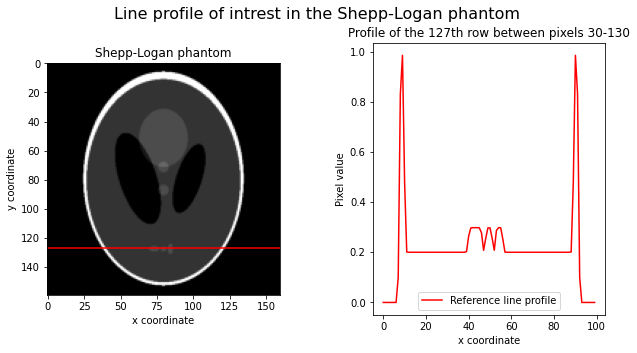

In [7]:
ref_line = Shepp_Logan[127, 30:130]

fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(1, 2, wspace=0.4, hspace=0.3)
fig.suptitle('Line profile of intrest in the Shepp-Logan phantom', fontsize=16)

shepp = fig.add_subplot(grid[0, 0])
shepp.imshow(Shepp_Logan)
shepp.axhline(127, c="red")
shepp.set_xlabel("x coordinate")
shepp.set_ylabel("y coordinate")
shepp.set_title("Shepp-Logan phantom")

prof = fig.add_subplot(grid[0, 1])
prof.plot(ref_line, label="Reference line profile", c="red")
prof.set_xlabel("x coordinate")
prof.set_ylabel("Pixel value")
prof.set_title("Profile of the 127th row between pixels 30-130")
prof.legend()

plt.show()

We will be looking at the $127$ row, the pixels between $30$ and $130$. As you can see by the profile there is a sharp increase in pixel value in the beginning and in the end which corresponds to the bones, and the tree tumors could be distinguished in the center of the $x$ axis.

In order to have comparable results we will be using the same parameters in our reconstructions - $150$ projection angles in the interval $[0, \pi]$

In [8]:
NUM_ANGLES = 150
END_THETA = np.pi

## Forward projection and image rotation

Forward projection or *Radon transform* $R_\theta(x')$ is the sum of a $2$d function $f(x,y)$ along a given line $y'$ that is rotated around a given point at an angle $\theta$.

![](data/img/Radon_transform.jpeg)

[source: Radon transform diagram from MATLAB online documentation](https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/AV0405/HAYDEN/Slice_Reconstruction.html)

In mathematical terms this can be expressed as

$$
R_\theta(x' )=\int^{+\infty}_{-\infty} = f(x',y')\mathrm{d}y'
$$

where $x'$ and $y'$  are the rotated coordinates at angle $\theta$. 

Since we will be using images which cannot be expressed as continuous function the formulae above should be modified. For an image that is $M$ x $N$ 

$$
Rf_\theta(x' )=\sum^{m}_{n=1} = f(x',y')\mathrm{d}y'
$$

That way we can simply sum the value of $y'$ along the rotated axis $x'$.


In order to rotate a point(in this case a pixel) we can use the rotation matrix $R$ where

$$
R = 
\begin{bmatrix}
\cos \theta & - \sin \theta\\
\sin \theta & \cos \theta 
\end{bmatrix}
$$

So to rotate a point in $p$ with coordinates $(x,y)$ by angle $\theta$ the expression becomes 


$$
p'=
Rp=
\begin{bmatrix}
\cos \theta & - \sin \theta\\
\sin \theta & \cos \theta 
\end{bmatrix} 
\begin{bmatrix}
x \\
y 
\end{bmatrix}
= 
\begin{bmatrix}
x\cos \theta  - y\sin \theta\\
x\sin \theta + y\cos \theta 
\end{bmatrix}
=
\begin{bmatrix}
x' \\
y' 
\end{bmatrix}
$$

This is the case for for a standard right-handed Cartesian coordinate system, where the direction of the $x$-axis is to the right and the $y$-axis is up. Sadly this is not the case, since when storing images in `np.array` the $y$ coordinate increases downwards. This problem could be solved by flipping $R$ to $R'$ so it corresponds.

$$
R' =
\begin{bmatrix}
-1 & 0\\
0 & 1 
\end{bmatrix}
R
= 
\begin{bmatrix}
-1 & 0\\
0 & 1 
\end{bmatrix}
\begin{bmatrix}
\cos \theta & - \sin \theta\\
\sin \theta & \cos \theta 
\end{bmatrix}
=
\begin{bmatrix}
\cos \theta & \sin \theta\\
-\sin \theta & \cos \theta 
\end{bmatrix}
$$

Using the modified rotation matrix $R'$ we can construct a function `rotate_image`. 
After rotating the pixel in the original image we get coordinates that are not whole numbers. This is to be expected and we have to round the coordinates to the nearest integer(pixel coordinate). By doing so we introduce some error in the resulting image. 

In [9]:
def rotate_image(image, theta):
    """
    Returns rotated image by angle theta. Image should be square.
    image -input 2d np.array
    theta - angle in radians.
    """
    img_x, img_y = image.shape
    assert img_x == img_y, 'Image should be square'

    img_size = img_x
    offset = img_size / 2

    x_cor, y_cor = np.meshgrid(
        np.arange(img_size) - offset,
        np.arange(img_size) - offset)
    x_cor = x_cor.flatten()
    y_cor = (y_cor).flatten()

    x_rot_cor = x_cor * np.cos(theta) + y_cor * np.sin(theta)
    y_rot_cor = -x_cor * np.sin(theta) + y_cor * np.cos(theta)

    x_rot_cor = np.round(x_rot_cor + offset).astype('int').flatten()
    y_rot_cor = np.round((y_rot_cor + offset)).astype('int').flatten()

    x_dest, y_dest = np.meshgrid(np.arange(img_size), (np.arange(img_size)))
    x_dest = x_dest.flatten()
    y_dest = y_dest.flatten()

    # find coordinates that are out of the image and delete the points
    x_del_cor = np.where((x_rot_cor < 0) | (x_rot_cor > img_size - 1))
    x_rot_cor = np.delete(x_rot_cor, x_del_cor)
    y_rot_cor = np.delete(y_rot_cor, x_del_cor)
    x_dest = np.delete(x_dest, x_del_cor)
    y_dest = np.delete(y_dest, x_del_cor)

    y_del_cor = np.where((y_rot_cor < 0) | (y_rot_cor > img_size - 1))
    x_rot_cor = np.delete(x_rot_cor, y_del_cor)
    y_rot_cor = np.delete(y_rot_cor, y_del_cor)
    x_dest = np.delete(x_dest, y_del_cor)
    y_dest = np.delete(y_dest, y_del_cor)

    rot_image = np.zeros_like(image)
    rot_image[x_dest, y_dest] = image[x_rot_cor, y_rot_cor]

    return rot_image

We can test the function by rotating by $\pi/4$

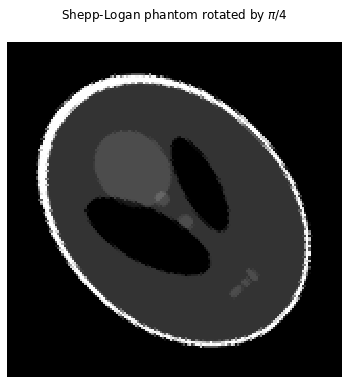

In [10]:
rot_image = rotate_image(Shepp_Logan, np.pi / 4)
plt.matshow(rot_image)
plt.axis('off')
plt.title("Shepp-Logan phantom rotated by $\pi$/4")
plt.show()

A good test of this function is to if we rotate it by $\pi/4$ and $ -\pi/4$  and see if we get the original image.

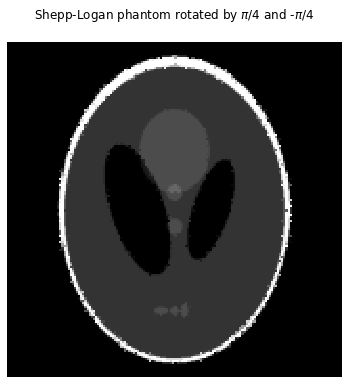

In [11]:
rot_image = rotate_image(rotate_image(Shepp_Logan, np.pi / 4), -np.pi / 4)
plt.matshow(rot_image)
plt.axis('off')
plt.title("Shepp-Logan phantom rotated by $\pi$/4 and -$\pi$/4")
plt.show()

The resulting image looks very similar to the original Shepp-Logan phantom, but to see the difference better we will plot it. 

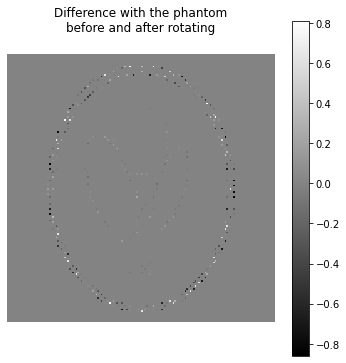

In [12]:
plt.matshow(Shepp_Logan - rot_image)
plt.axis('off')
plt.colorbar()
plt.title("Difference with the phantom\nbefore and after rotating")
plt.show()

As you can see there are some points that differ with the original image. These points are not evenly distributed since there are a lot of areas, where the pixel values are the same (within the phantom and outside of it) so a small deviation in the coordinate does not change the value of the pixel.

One way to conquer this problem is by interpolating the rotated coordinates onto the image grid space using the `scipy.interpolate` function.

In [13]:
def rotate_image_interp(image, theta, interp='cubic'):
    """
    Returns rotated image by angle theta.This function uses scipy interpolate function.Image should be square.
    image  - input 2d np.array
    theta  - angle in radians.
    interp - interpolation method
    """
    img_x, img_y = image.shape
    assert img_x == img_y, 'Image should be square'

    img_size = img_x
    offset = img_size / 2

    x_cor, y_cor = np.meshgrid(
        np.arange(img_size) - offset, (np.arange(img_size)) - offset)
    x_cor = x_cor.flatten()
    y_cor = (y_cor).flatten()

    x_rot_cor = x_cor * np.cos(theta) + y_cor * np.sin(theta)
    y_rot_cor = -x_cor * np.sin(theta) + y_cor * np.cos(theta)
    x_rot_cor = (x_rot_cor + offset).flatten()
    y_rot_cor = (y_rot_cor + offset).flatten()

    x_dest, y_dest = np.meshgrid(np.arange(img_size), (np.arange(img_size)))
    x_dest = x_dest.flatten()
    y_dest = y_dest.flatten()

    rot_image = scipy.interpolate.griddata(points=(x_rot_cor, y_rot_cor),
                                           values=image.flatten(),
                                           xi=(x_dest, y_dest),
                                           method=interp,
                                           fill_value=0.0).reshape(
                                               (img_size, img_size))
    return rot_image

We can test the `rotate_image_interp` the same way

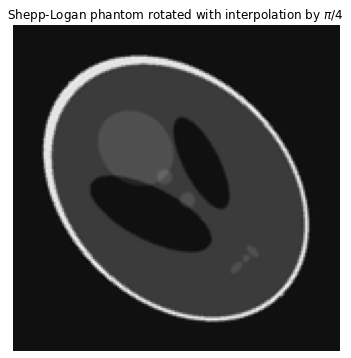

In [14]:
rot_image = rotate_image_interp(Shepp_Logan, np.pi/4)
plt.imshow(rot_image)
plt.axis('off')
plt.title("Shepp-Logan phantom rotated with interpolation by $\pi$/4 ")
plt.show()

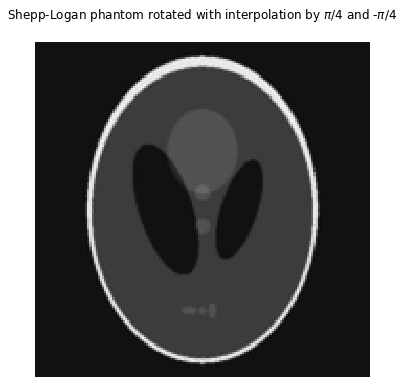

In [15]:
rot_image = rotate_image_interp(rotate_image_interp(Shepp_Logan, np.pi / 4), -np.pi / 4)
plt.matshow(rot_image)
plt.axis('off')
plt.title("Shepp-Logan phantom rotated with interpolation by $\pi$/4 and -$\pi$/4")
plt.show()

And now to see the difference 

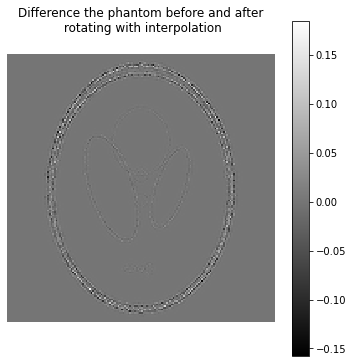

In [16]:
plt.matshow(Shepp_Logan - rot_image)
plt.axis('off')
plt.colorbar()
plt.title("Difference the phantom before and after\n rotating with interpolation")
plt.show()

The difference of the result of the two functions and the original image is visually similar, but as you can see the scale the `rotate_image_interp` performs significantly better as the differences are quite smaller smaller. 

We have to note is that the `rotate_image` function is faster and we will use it, as the aim of this notebook is to show the basic principles of the algorithms and not optimize them.

After constructing a rotating function, the forward projection is straightforward - we rotate the image around it's center at an angle $\theta$ and then we take the sum of the columns. The resulting image, which is constructed by rotating with many different angles is called a sinogram.

In [17]:
def forward_projection(image,
                       num_angles,
                       end_theta=np.pi,
                       interpolate=False):
    """
    Forward projects an image using Radon transform to a sinogram.
    Image should be square.
    """
    img_x, img_y = image.shape
    assert img_x == img_y, 'Image should be square'

    img_size = img_x
    theta = np.arange(0, end_theta, end_theta / num_angles)

    sinogram = np.zeros((num_angles, img_size))

    for n in range(num_angles):

        if interpolate:
            rot_image = rotate_image_interp(image, theta[n])
        else:
            rot_image = rotate_image(image, theta[n])

        sinogram[n] = rot_image.sum(axis=0)

    return sinogram

Now let's build our sinogram!

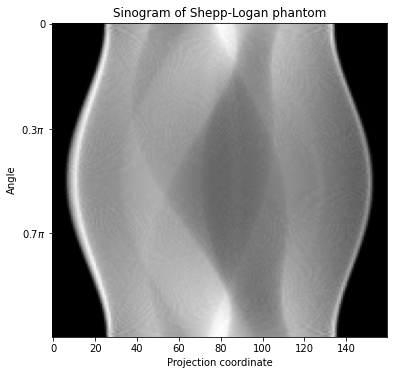

In [18]:
sinogram = forward_projection(Shepp_Logan,
                              num_angles=NUM_ANGLES,
                              end_theta=END_THETA,
                              interpolate=False)
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(sinogram)
ax.set_title("Sinogram of Shepp-Logan phantom")
ax.set_xlabel('Projection coordinate')
ax.set_ylabel('Angle')

ax.yaxis.set_major_formatter(
    FuncFormatter(lambda val, pos: '{:.1g}$\pi$'.format(
        ((val) * END_THETA) / ((NUM_ANGLES) * np.pi)) if val != 0 else '0'))
ax.yaxis.set_major_locator(MultipleLocator(base=NUM_ANGLES / 3))
### Credit to Scott Centoni ###
### https://stackoverflow.com/questions/40642061/how-to-set-axis-ticks-in-multiples-of-pi-python-matplotlib ###

plt.show()

For better visual representation I have written a function that creates a ".gif" file that animates the Radon transform. Since the function `v_forward_projection` that does this could be more confusing than the previously defined functions, I have left the visualizations in a different file file called `v_reconstruction.py` that is imported at the beginning of the project.

In [19]:
# v_forward_projection("FP",Shepp_Logan,NUM_ANGLES,end_theta=END_THETA)

![](data/gif/FP.gif "Forward projection")

## Analytic Reconstruction Algorithms 

Usually when we are given the task to reconstruct a slice or volumetric data we are given the sinogram. This is what the CT imaging system obtains as the X-ray source and detectors rotate around the patient. This sinogram is often noisy and and has artifacts, but for now we will not introduce them in our model.

Since this is an active area of research there are a lot of algorithms that are developed for the reconstruction of images. The ones that are we are going to look in this section were the method of choice until $2009$, when the first iterative algorithm was released for clinical use.

### Back projection 

One of the most widely spread methods for image reconstruction is the back projection or the inverse Radon transform introduced in $1917$ by Johann Radon.  
 Since this is a showcase of the algorithms we will not be normalizing the values of the back projection reconstruction rather than that we will make a *min-max* normalization. Due to this we will not be calculating the RMS values.

In mathematical terms the reconstructed function $f_r(x,y)$ is obtained by integrating the sinogram $R(x',\theta)$ for all angles.

$$\large
f_r(x,y) = \int_0^\pi R(x',\theta) \mathrm{d}\theta
$$

or in the discrete case

$$\large
f_r(x,y) =\Delta \theta_p \sum_{p=1}^k R(x',\theta _p)
$$
where  $\Delta \theta_p$ is the angular distance between projections.

In other words each of the sinogram rows is rotated by their corresponding angle and projected on the reconstruction image.

In [20]:
def back_projection(sinogram, end_theta=np.pi, norm=False):
    """
    Returns the backprojection of the sinogram

    sinogram - sinogram to be used for the reconstruction.Should be np.array
    end_theta - the angle that coresponds to the last row, assuming that the data is evenly distributed
    """

    num_angles, img_size = sinogram.shape
    offset = img_size / 2
    theta = np.arange(0, end_theta, end_theta / num_angles)

    x_cor, y_cor = np.meshgrid(
        np.arange(img_size) - offset, (np.arange(img_size)) - offset)

    recon_matrix = np.zeros((img_size, img_size))

    for n in range(num_angles):

        proj_matrix = np.zeros((img_size, img_size))

        x_rot_cor = x_cor * np.cos(theta[n]) + y_cor * np.sin(theta[n])
        x_rot_cor = np.round(x_rot_cor + offset).astype('int')

        x_rot_cor[(x_rot_cor < 0) | (x_rot_cor > img_size)] = img_size
        s = np.append(sinogram[n], 0)

        recon_matrix += s[x_rot_cor]

    if norm:
        min_value = np.min(recon_matrix)
        max_value = np.max(recon_matrix)
        return (recon_matrix-min_value)/(max_value-min_value)
    else:
        return recon_matrix*(end_theta/num_angles)

In [21]:
reconstruction = back_projection(sinogram, end_theta=END_THETA, norm=True)

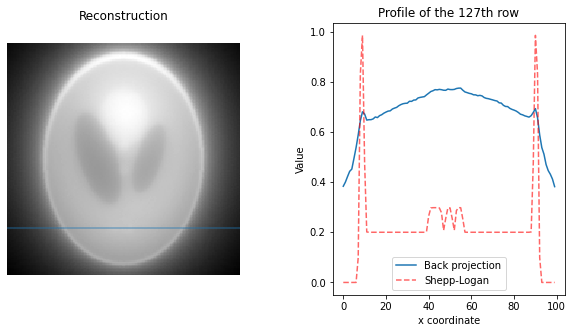

In [22]:
fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(1, 2, wspace=0.4, hspace=0.3)

reconst = fig.add_subplot(grid[0, 0])
reconst.matshow(reconstruction)
reconst.set_axis_off()
reconst.axhline(127, alpha=0.5)
reconst.set_title("Reconstruction")

ax_line = fig.add_subplot(grid[0, 1])
ax_line.plot(reconstruction[127, 30:130], label="Back projection")
ax_line.plot(ref_line, "--", c="r", label="Shepp-Logan", alpha=0.6)
ax_line.set_xlabel("x coordinate")
ax_line.set_ylabel("Value")
ax_line.legend()
ax_line.set_title("Profile of the 127th row")
plt.show()

As you can see we the reconstruction is very blurry and has a halo around the center of the image. This is to be expected because in the center of the image more projections are summed. It is important to note here that the inverse Radon transform does not return the original function, but rather an approximation

Using the function `v_back_projection` from the `V_reconstruction` file we could visualize the the process better

In [23]:
# v_back_projection("BP",sinogram,end_theta=END_THETA)

![](data/gif/BP.gif "Back projection")

#### Filtered back projection

In order to make the reconstruction image $f_r(x,y)$ better we could use a filter. The most common filter is the low pass filter or the ramp filter. It is most easily defined in the frequency domain as it is simply $|v|$, where $v$ is the frequency. Since in the spatial domain the filter has a rather complicated form it is much easier for us to apply it in the Fourier domain.

For the Fourier transformations we will be using the `numpy` library.

![](data/img/Ramp_f.jpeg)

[source:snmjournals.org](https://jnm.snmjournals.org/content/42/10/1499/tab-figures-data )

In [24]:
def create_ramp_filter(size):
    """
    Returns ramp filter with size 'size'.
    The function assumes that the frequencies are in assending order starting from "-freq" to "freq" 
    """

    return np.abs(np.linspace(1, -1, size))

It is important to note here that the function `create_ramp_filter` assumes that the frequency $v_0=-v_{\mathrm{size}-1}$ or in other words that the frequency with value $0$ is in position $\mathrm{size}/2$.

We can make a quick visualization to check if everything looks good. In order to do this we will make a signal that has values $1$ in the whole specter and then apply the filter to it.

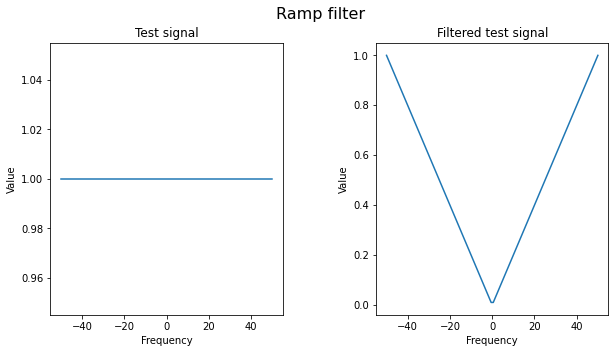

In [25]:
# defining the mock signal
sig_points = 100
sig_value = np.ones(sig_points)
sig_freq = np.linspace(-sig_points/2, sig_points/2, sig_points)


fig = plt.figure(figsize=(10, 5))
fig.tight_layout()
fig.suptitle('Ramp filter', fontsize=16)
grid = plt.GridSpec(1, 2, wspace=0.4, hspace=0.3)

sig = fig.add_subplot(grid[0, 0])
sig.plot(sig_freq, sig_value)
sig.set_xlabel("Frequency")
sig.set_ylabel("Value")
sig.set_title("Test signal")

ramp = create_ramp_filter(sig_points)

f_sig = fig.add_subplot(grid[0, 1])
f_sig.plot(sig_freq, np.abs(sig_value*ramp))
f_sig.set_xlabel("Frequency")
f_sig.set_ylabel("Value")
f_sig.set_title("Filtered test signal")

plt.show()

It can be easily seen that the filter works as expected. Now we can define a function `filter_sinogram` that applies the filter to the whole sinogram.

In [26]:
def filter_sinogram(sinogram):
    """
    Returns the sinogram with applied ramp filter.
    The function assumes that the frequencies are in assending order starting from "-freq" to "freq" 
    """
    num_angles, img_size = sinogram.shape

    # create filter in the frequency domain and shift it
    filt = create_ramp_filter(img_size)
    filt = np.fft.fftshift(filt)

    fourier_space = np.fft.fft(sinogram)
    real_space = np.fft.ifft(fourier_space * filt)

    return np.real(real_space)

Here `np.fft.fftshift` is used in order to shift the frequency so that the zero is in the center of the frequency domain. This is done because `np.fft.fft` computes only the positive frequencies of the spectrum in order to save computation time. The second half is the complex conjugate of the first half and it is just added at the end of the vector -this is a valid result because of the periodicity of the Fourier transform.


![](data/img/fft-shift2.jpeg)

[source:pysdr.org](https://pysdr.org/content/frequency_domain.html)

Now let's visualize the filtered sinogram.

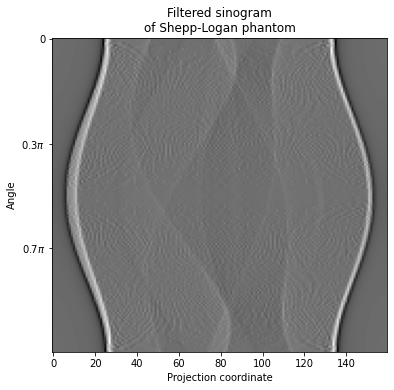

In [27]:
filtered_sin = filter_sinogram(sinogram)

fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(filtered_sin)
ax.set_title("Filtered sinogram\nof Shepp-Logan phantom")
ax.set_xlabel('Projection coordinate')
ax.set_ylabel('Angle')

ax.yaxis.set_major_formatter(
    FuncFormatter(lambda val, pos: '{:.1g}$\pi$'.format(
        ((val) * END_THETA) / ((NUM_ANGLES) * np.pi)) if val != 0 else '0'))
ax.yaxis.set_major_locator(MultipleLocator(base=NUM_ANGLES / 3))

And we can define a function that does the filtered back projection.

In [28]:
def filtered_back_projection(sinogram, end_theta=np.pi, norm=False):
    """
    Returns the filtered back projection of the given sinogram
    """
    filtered_sin = filter_sinogram(sinogram)
    reconstruction = back_projection(filtered_sin, end_theta)
    if norm:
        min_value = np.min(reconstruction)
        max_value = np.max(reconstruction)

        return (reconstruction - min_value) / (max_value - min_value)
    else:
        return reconstruction

In [29]:
filt_reconstruction = back_projection(filtered_sin, end_theta=END_THETA, norm=True)

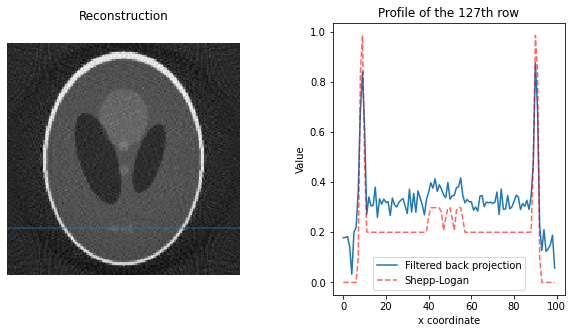

In [30]:
fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(1, 2, wspace=0.4, hspace=0.3)

reconst = fig.add_subplot(grid[0, 0])
reconst.matshow(filt_reconstruction)
reconst.set_axis_off()
reconst.axhline(127, alpha=0.5)
reconst.set_title("Reconstruction")

ax_line = fig.add_subplot(grid[0, 1])
ax_line.plot(filt_reconstruction[127, 30:130], label="Filtered back projection")
ax_line.plot(ref_line, "--", c="r", label="Shepp-Logan", alpha=0.6)
ax_line.set_xlabel("x coordinate")
ax_line.set_ylabel("Value")
ax_line.legend()
ax_line.set_title("Profile of the 127th row")
plt.show()

Using the filter has greatly suppressed the artifacts and improved the image quolity. The three hematoma in the middle of the projection could now be seen.

We can again visualize the reconstruction using the function `v_back_projection` from the `v_reconstruction` file.

In [31]:
#  v_back_projection("f_BP",filtered_sin,end_theta=END_THETA)

![](data/gif/f_BP.gif "Filtered back projection")

### Projection slice theorem reconstruction

Another common method for CT reconstruction is using the projection slice theorem. It states that a line through the center of a $2\mathrm{D}$ Fourier transform $F(\omega \cos \theta, \omega \sin \theta)$ of a object $f(x,y)$ at an angle $\theta$ is identical to the $1\mathrm{D}$ Fourier transform $P(\omega, \theta)$ of the Radon transform at an angle $\theta$.

![](data/img/CST.jpeg)

[source: Maier Andreas](https://www5.cs.fau.de/fileadmin/persons/MaierAndreas/maier/Hornegger16-CRB.pdf)

Simply said we need to take the following steps in order to make the reconstruction

1. Obtain the sinogram
2. Apply a $1\mathrm{D}$ Fourier transform to each of the projections $P(\omega, \theta)$
3. Align each projection $P(\omega, \theta)$ as a central profile at angle $\theta$ 
4. Make a $2\mathrm{D}$ inverse Fourier transform to obtain the reconstruction

To align the projections is fairly straight forward - we take each row of the sinogram and rotate it by angle $\theta$ at which the projection was made. When rotating with the matrix $R$ we have to keep in mind that the $y$ coordinate is $0$ which means that:

$$
x' = r\cos\theta \\
y' = r\sin\theta
$$

Here $r$ is the distance form the point of rotation or the image center in our case

In [32]:
def align_projections(sinogram, end_theta=np.pi):
    """
    aligns the fft transformed projections onto Fourier space
    """
    num_angles, img_size = sinogram.shape
    offset = img_size / 2

    theta = np.arange(0, end_theta, end_theta / num_angles)
    fft2 = np.zeros((img_size, img_size), dtype="complex")

    # create source coordinates
    x_source, y_source = np.meshgrid(np.arange(img_size), np.arange(num_angles))
    x_source = x_source.flatten()
    y_source = y_source.flatten()

    # create the destination coordinates
    r, ange = np.meshgrid(np.arange(img_size) - offset, np.arange(num_angles))
    x_dest = r * np.cos(theta[ange])
    y_dest = r * np.sin(theta[ange])

    # round to nearest integer
    x_dest = np.round(x_dest + offset).astype('int').flatten()
    y_dest = np.round(y_dest + offset).astype('int').flatten()

    # find coordinates that are out of the image and delete the points
    x_del_cor = np.where((x_dest < 0) | (x_dest > img_size - 1))
    x_dest = np.delete(x_dest, x_del_cor)
    y_dest = np.delete(y_dest, x_del_cor)
    x_source = np.delete(x_source, x_del_cor)
    y_source = np.delete(y_source, x_del_cor)

    y_del_cor = np.where((y_dest < 0) | (y_dest > img_size - 1))
    x_dest = np.delete(x_dest, y_del_cor)
    y_dest = np.delete(y_dest, y_del_cor)
    x_source = np.delete(x_source, y_del_cor)
    y_source = np.delete(y_source, y_del_cor)

    fft2[y_dest, x_dest] = sinogram[y_source, x_source]

    return fft2

As is the case with the `rotate_image` function we could use interpolation to minimize our rounding errors. We will again use the `scipy.interpolate.griddata` function to help us with that.

In [33]:
def align_projections_interp(sinogram, end_theta=np.pi, interp='linear'):
    """
    aligns the fft transformed projections onto Fourier space using "interp" interpolation
    """
    num_angles, img_size = sinogram.shape
    offset = img_size / 2
    theta = np.arange(0, end_theta, end_theta / num_angles)

    # create source coordinates
    x_source, y_source = np.meshgrid(np.arange(img_size), np.arange(img_size))
    x_source = x_source.flatten()
    y_source = y_source.flatten()

    # create the destination coordinates
    r, theta = np.meshgrid(np.arange(img_size) - offset, theta)
    x_dest = (r * np.cos(theta) + offset).flatten()
    y_dest = (r * np.sin(theta) + offset).flatten()

    fft2 = scipy.interpolate.griddata(points=(x_dest,
                                              y_dest),
                                      values=sinogram.flatten(),
                                      xi=(x_source, y_source),
                                      method=interp,
                                      fill_value=0.0).reshape(
                                          (img_size, img_size))

    return fft2

Now we can make a function `CST_transform` which reconstructs the image from a given sinogram.

In [34]:
def CST_transform(sinogram, end_theta=np.pi, interp='cubic'):
    """
    Returns a central slice theorem reconstruction of the sinogram
    """
    ft_sin = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(sinogram)))
    
    if interp:
        fs = align_projections_interp(ft_sin,end_theta=end_theta, interp=interp)
    else:
        
        fs = align_projections(ft_sin,end_theta=end_theta)

    reconstruction = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(fs)))

    return np.real(reconstruction)

Using the `v_CST_transform` from the `v_reconstruction` file we can better visualize the algorithm.

In [35]:
# v_CST_transform("CST",sinogram,end_theta=END_THETA)

![](data/gif/CST.gif "Projection slice theorem reconstruction")

Let's have a look at some of the results.

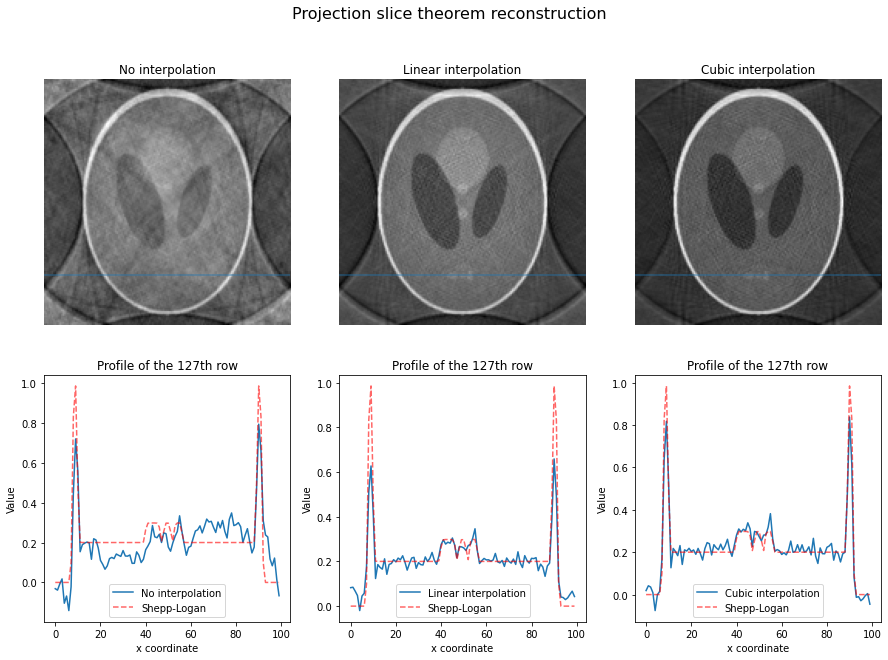

In [36]:
CST_recon = CST_transform(sinogram, end_theta=END_THETA, interp=False)
CST_recon_linear = CST_transform(sinogram, end_theta=END_THETA, interp="linear")
CST_recon_cubic = CST_transform(sinogram, end_theta=END_THETA, interp="cubic")


fig = plt.figure(figsize=(15, 10))
fig.tight_layout()
fig.suptitle('Projection slice theorem reconstruction', fontsize=16)
grid = plt.GridSpec(2, 3)

cst = fig.add_subplot(grid[0, 0])
cst.imshow(CST_recon)
cst.set_axis_off()
cst.axhline(127, alpha=0.5)
cst.set_title("No interpolation")

cst_line = fig.add_subplot(grid[1, 0])
cst_line.plot(CST_recon[127, 30:130], label="No interpolation")
cst_line.plot(ref_line, "--", c="r", label="Shepp-Logan", alpha=0.6)
cst_line.set_xlabel("x coordinate")
cst_line.set_ylabel("Value")
cst_line.legend()
cst_line.set_title("Profile of the 127th row")

cst_lin = fig.add_subplot(grid[0, 1])
cst_lin.imshow(CST_recon_linear)
cst_lin.set_axis_off()
cst_lin.axhline(127, alpha=0.5)
cst_lin.set_title("Linear interpolation")

cst_line = fig.add_subplot(grid[1, 1])
cst_line.plot(CST_recon_linear[127, 30:130], label="Linear interpolation")
cst_line.plot(ref_line, "--", c="r", label="Shepp-Logan", alpha=0.6)
cst_line.set_xlabel("x coordinate")
cst_line.set_ylabel("Value")
cst_line.legend()
cst_line.set_title("Profile of the 127th row")

cst_cub = fig.add_subplot(grid[0, 2])
cst_cub.imshow(CST_recon_cubic)
cst_cub.set_axis_off()
cst_cub.axhline(127, alpha=0.5)
cst_cub.set_title("Cubic interpolation")

cst_line = fig.add_subplot(grid[1, 2])
cst_line.plot(CST_recon_cubic[127, 30:130], label="Cubic interpolation")
cst_line.plot(ref_line, "--", c="r", label="Shepp-Logan", alpha=0.6)
cst_line.set_xlabel("x coordinate")
cst_line.set_ylabel("Value")
cst_line.legend()
cst_line.set_title("Profile of the 127th row")


plt.show()

As you can see the quality of the reconstruction significantly increases with the usage of interpolation. Another thing we can note that the more complex interpolation is (*linear -> cubic*), the more artifacts are suppressed.

Now let's calculate the RMS values

In [37]:
rms_CST = calculate_RMS(CST_recon, Shepp_Logan)
rms_CST_lin = calculate_RMS(CST_recon_linear, Shepp_Logan)
rms_CST_cub = calculate_RMS(CST_recon_cubic, Shepp_Logan)

print("RMS for CST reconstruction without interpolation is {:.3f}".format(rms_CST))
print("RMS for CST reconstruction with linear interpolation is {:.3f}".format(rms_CST_lin))
print("RMS for CST reconstruction with cubic interpolation is {:.3f}".format(rms_CST_cub))

RMS for CST reconstruction without interpolation is 0.146
RMS for CST reconstruction with linear interpolation is 0.094
RMS for CST reconstruction with cubic interpolation is 0.059


As expected the RMS value decreases with the complexity of the interpolation algorithm.

#### Adding a padding

There are a few steps that can be done in order to improve the reconstruction quality. One of them is to add a padding to the original image in order to reduce some of the artifacts.

First we need to write some helping functions in order to add and then remove the padding

In [38]:
def add_padding(image, padding):
    """
    Returns the image padded by 'padding' on all four sides
    """
    padding = int(np.round(padding))
    return np.pad(image, (padding, padding), 'constant', constant_values=0)


def crop_center(image, value):
    """
    Returns the image cropped by 'value' on all four sides
    """
    x, y = image.shape
    value = int(np.round(value))
    return image[value:x - value, value:y - value]

Now let's generate the padded sinogram.

In [39]:
Shepp_Logan_pad = add_padding(Shepp_Logan, padding=40)

pad_sinogram = forward_projection(Shepp_Logan_pad,
                                  num_angles=NUM_ANGLES,
                                  end_theta=END_THETA,
                                  interpolate=False)

Again we can add a visualization of the padded reconstruction using the `v_CST_transform` function.

In [40]:
# v_CST_transform("pad_CST1",pad_sinogram,end_theta=END_THETA)

![](data/gif/pad_CST.gif "Projection slice theorem reconstruction")

Lets compare the results with and without padding

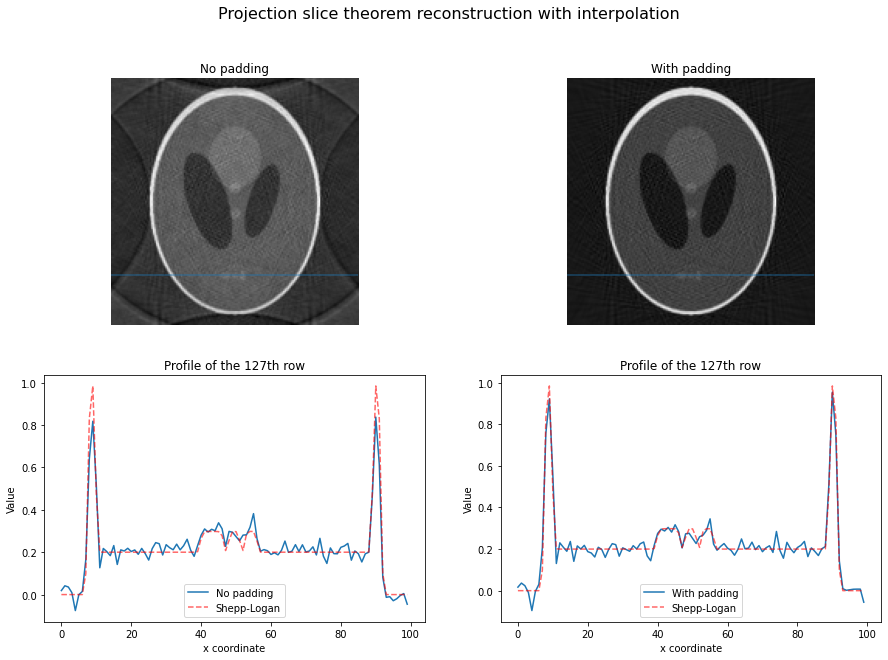

In [41]:
CST_recon_cubic = CST_transform(sinogram, end_theta=END_THETA, interp="cubic")

CST_recon_pad = CST_transform(pad_sinogram, end_theta=END_THETA, interp="cubic")
CST_recon_pad = crop_center(CST_recon_pad, value=40)


fig = plt.figure(figsize=(15, 10))
fig.tight_layout()
fig.suptitle('Projection slice theorem reconstruction with interpolation', fontsize=16)
grid = plt.GridSpec(2, 2)

cst = fig.add_subplot(grid[0, 0])
cst.imshow(CST_recon_cubic)
cst.set_axis_off()
cst.axhline(127, alpha=0.5)
cst.set_title("No padding")

cst_line = fig.add_subplot(grid[1, 0])
cst_line.plot(CST_recon_cubic[127, 30:130], label="No padding")
cst_line.plot(ref_line, "--", c="r", label="Shepp-Logan", alpha=0.6)
cst_line.set_xlabel("x coordinate")
cst_line.set_ylabel("Value")
cst_line.legend()
cst_line.set_title("Profile of the 127th row")

cst_pad = fig.add_subplot(grid[0, 1])
cst_pad.imshow(CST_recon_pad)
cst_pad.set_axis_off()
cst_pad.axhline(127, alpha=0.5)
cst_pad.set_title("With padding")

cst_pad_line = fig.add_subplot(grid[1, 1])
cst_pad_line.plot(CST_recon_pad[127, 30:130], label="With padding")
cst_pad_line.plot(ref_line, "--", c="r", label="Shepp-Logan", alpha=0.6)
cst_pad_line.set_xlabel("x coordinate")
cst_pad_line.set_ylabel("Value")
cst_pad_line.legend()
cst_pad_line.set_title("Profile of the 127th row")


plt.show()

As you can see most of the artifacts around the phantom has disappeared, but still there are a lot of issues with the homogeneity of the reconstruction.

The RMS values are as follows

In [42]:
rms_CST_cub = calculate_RMS(CST_recon_cubic, Shepp_Logan)
rms_CST_cub_pad = calculate_RMS(CST_recon_pad, Shepp_Logan)

print("RMS for CST reconstruction without padding is {:.3f}".format(rms_CST_cub))
print("RMS for CST reconstruction with padding is {:.3f}".format(rms_CST_cub_pad))

RMS for CST reconstruction without padding is 0.059
RMS for CST reconstruction with padding is 0.032


## Iterative reconstruction algorithms

In recent years iterative reconstruction algorithms has become more widely used in clinical settings for computed tomographic imaging. There are a lot of evidence that the iterative algorithms preform better than the established analytical methods such as filtered back projection by suppressing noise, artifacts and potentially reducing patient dose, but usually the trade off is the computational requirements and time. These algorithms begin with an initial image assumption and compare it to the measured data, adjusting the result in each iteration.

### Simultaneous Algebraic Reconstruction Technique

The Simultaneous Algebraic Reconstruction Technique(SART) is first introduced by *A. H. Anderson* and *A. C. Kak* in the year $1984$ year as an variation of the Algebraic Reconstruction Technique(ART) algorithm. Here we will not be looking into the ART algorithm, but rather try to implement SART.

They define the iterative algorithm as such:

$$\large
R^{k+1} = R^k + \frac{\sum \limits_j \left[a_{ij}\frac{p_j - a_j^T R^k}{\sum \limits_i^N w_{ij}}\right]}{\sum \limits_j w_{ij}}
$$

Where   
$R$ - reconstruction  
$k$ - iteration number  
$p$ - projection   
$i$ - row index    
$j$ - column index    
$w$ - weight coefficients  

In order to be more readable we will denote the SART algorithm in operator notation, where $A$ will be the forward projection operator and $A^T$ the back projection operator 

$$ \large
R^{k+1} = R^k + \frac{{ A^T \frac{p_i - A R^k}{A w_i}}}{A^T w_j}
$$

To find the weight coefficients $w$ we could use a uniform matrix of ones in order to see how $A$ and $A^T$ transform them.

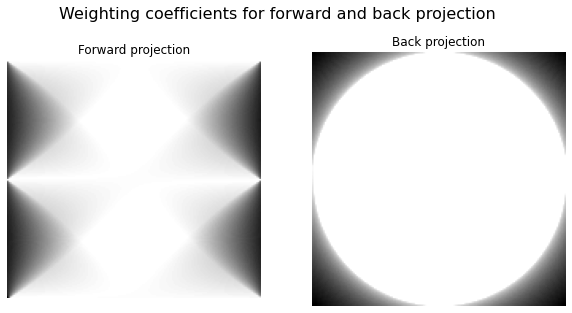

In [43]:
w_r = forward_projection(np.ones_like(Shepp_Logan), num_angles=NUM_ANGLES)
w_c = back_projection(np.ones_like(sinogram))

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()
fig.suptitle('Weighting coefficients for forward and back projection', fontsize=16)
grid = plt.GridSpec(1, 2)

w_rows = fig.add_subplot(grid[0, 0])
w_rows.imshow(w_r)
w_rows.set_axis_off()
w_rows.set_title("Forward projection")

w_columns = fig.add_subplot(grid[0, 1])
w_columns.imshow(w_c)
w_columns.set_axis_off()
w_columns.set_title("Back projection")

plt.show()

As you can see the transformations are not ideal and introduce a lot of artifacts. In order to reduce the inhomogeneity of the results we will be dividing the resulting forward and back projections by them - as is shown in the formulae above.

The iterative formula can be summarized as follows:
1. Initialize a zero reconstruction of all of all zeros $R^{k=0}$
1. Find the forward projection of the current iteration `c_s`
3. Find the difference between the sinograms of the current iteration and the image we are trying to reconstruct `s_dif`
4. Divide by the the forward projection weight `w_r`
5. Back project the result and divide by the back projection weight coefficients  `w_c`
6. Add the result to get the value of the next iteration
7. Repeat steps 2-6 for the desired number of iterations

In the function we are going to build we will introduce the functionality of calculating the RMSE between a given image and the reconstruction. This will be done in order to see when the algorithm has converged.

In [44]:
def sart(sinogram,
         end_theta=np.pi,
         iterations=20,
         interpolate=False,
         RMS_image=None):
    """
    Returns the SART reconstruction of a sinogram after `iterations` iterations.
    interpolate - if interpolation should be used in forward projection
    RMS_image - reference image to calculate RMSE
    Return - List where the first element is the reconstruction and the second element is a list of the RMSE values
    """
    rms = []

    num_angles, img_size = sinogram.shape

    if RMS_image is not None:
        assert RMS_image.shape == (
            img_size, img_size), 'The Reconstruction image and the RMS image are with different shapes'

    w_r = forward_projection(np.ones((img_size, img_size)),
                             num_angles=num_angles,
                             end_theta=end_theta,
                             interpolate=interpolate)

    w_c = back_projection(np.ones_like(sinogram),
                          end_theta=end_theta,
                          norm=False)

    c_r = np.zeros((img_size, img_size))
    for i in range(iterations):

        c_s = forward_projection(c_r,
                                 num_angles,
                                 end_theta=end_theta,
                                 interpolate=interpolate)
        s_dif = sinogram - c_s
        proj = back_projection(s_dif / w_r,
                               end_theta=end_theta,
                               norm=False) / w_c
        c_r = c_r + proj

        # This is needed for convergence
        c_r[c_r < 0] = 0
        c_r[c_r > 1] = 1

        if RMS_image is not None:
            rms.append(calculate_RMS(c_r, RMS_image))

    if RMS_image is not None:
        return [c_r, np.array(rms)]
    else:
        return [c_r]

Now let's test it for $20$ iterations  
*The next cell will execute very slow*

In [45]:
r_sart, rms_sart = sart(sinogram, iterations=20, interpolate=False, RMS_image=Shepp_Logan)

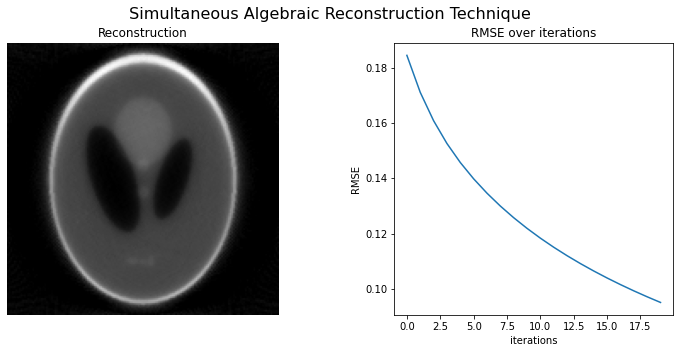

RMS for ISRA reconstruction with 1500 iterations is 0.0951


In [46]:
fig = plt.figure(figsize=(12, 5))
fig.tight_layout()
fig.suptitle(' Simultaneous Algebraic Reconstruction Technique', fontsize=16)
grid = plt.GridSpec(1, 2, wspace=0.4, hspace=0.3)

recostr_sart = fig.add_subplot(grid[0, 0])
recostr_sart.imshow(r_sart)
recostr_sart.set_axis_off()
recostr_sart.set_title("Reconstruction")

ax_RMS = fig.add_subplot(grid[0, 1])
ax_RMS.plot(rms_sart)
ax_RMS.set_xlabel("iterations")
ax_RMS.set_ylabel("RMSE")
ax_RMS.set_title("RMSE over iterations")

plt.show()

rms_sart_20 = calculate_RMS(r_sart, Shepp_Logan)

print("RMS for ISRA reconstruction with 1500 iterations is {:.4f}".format(rms_sart_20))

The algorithm is working as expected - the projection looks like the original Shepp Logan phantom and the RMSE is declining over time.  We could visualize the algorithm better using the `v_sart` function.

In [47]:
# v_sart("sart", Shepp_Logan, end_theta=END_THETA, iterations=100)

![](data/gif/sart.gif "Simultaneous Algebraic Reconstruction Technique")

In order to see how many iterations are needed for convergence we will run the function for $1500$ iterations. Since this will take a lot of time the final state of the matrix will be saved locally.

In [48]:
# # This cell is comented due to long execution time. The resulting plots are saved localy 

# r_sart,rms_sart = sart(sinogram, iterations=1500,interpolate=False,RMS_image=Shepp_Logan)

In [49]:
# # This cell should be uncomented if the cell above is executed. 

# min_rms = np.min(rms_sart)
# min_rms_pos = np.where(rms_sart == min_rms)
# min_rms_pos = min_rms_pos[0][0]

# fig = plt.figure(figsize=(12, 5))
# fig.tight_layout()
# fig.suptitle(' Simultaneous Algebraic Reconstruction Technique', fontsize=16)
# grid = plt.GridSpec(1, 2, wspace=0.4, hspace=0.3)

# recostr_sart = fig.add_subplot(grid[0, 0])
# recostr_sart.imshow(r_sart)
# recostr_sart.set_axis_off()
# recostr_sart.set_title("Reconstruction")

# ax_RMS = fig.add_subplot(grid[0, 1])
# ax_RMS.plot(rms_sart)
# ax_RMS.axvline(min_rms_pos, c="red", alpha = 0.5, label="RMS min={:.3f}\nat {} iteration".format(min_rms,min_rms_pos))
# ax_RMS.set_xlabel("iterations")
# ax_RMS.set_ylabel("RMSE")
# ax_RMS.set_title("RMSE over iterations")
# ax_RMS.legend()

# plt.show()

![](data/saved_plots/SART_conv.png)

As you can see SART converges after many iterations. We will assume that it has reached convergence at $1500$ iterations.

Now let's save the state of the reconstruction.

In [50]:
# # This cell shoud be uncommented only if the cells above are executed

# np.save('data/save_states/r_sart_1500.npy', r_sart)
# np.save('data/save_states/rms_sart.npy', rms_sart)

In [51]:
# If the cell above is not executed the results of the execution should be loaded

r_sart_1500 = np.load('data/save_states/r_sart_1500.npy')
rms_sart = np.load('data/save_states/rms_sart.npy')

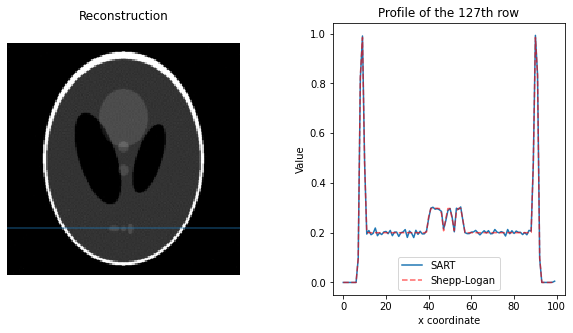

In [52]:
fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(1, 2, wspace=0.4, hspace=0.3)

recostr_sart = fig.add_subplot(grid[0, 0])
recostr_sart.matshow(r_sart_1500)
recostr_sart.set_axis_off()
recostr_sart.axhline(127, alpha=0.5)
recostr_sart.set_title("Reconstruction")

ax_line = fig.add_subplot(grid[0, 1])
ax_line.plot(r_sart_1500[127, 30:130], label="SART")
ax_line.plot(ref_line, "--", c="r", label="Shepp-Logan", alpha=0.6)
ax_line.set_xlabel("x coordinate")
ax_line.set_ylabel("Value")
ax_line.legend()
ax_line.set_title("Profile of the 127th row")
plt.show()

As you can see the reconstruction is nearly perfect and the tree tumors can be destinguished as good as in the original image. This should be shown as well in the RMS value

In [53]:
rms_sart_1500 = calculate_RMS(r_sart_1500, Shepp_Logan)

print("RMS for SART reconstruction with 1500 iterations is {:.4f}".format(rms_sart_1500))

RMS for SART reconstruction with 1500 iterations is 0.0056


### Image Space Reconstruction Algorithm

This algorithm is first proposed in $1986$ by M E Daube-Witherspoon and G Muehllehner in their paper "*An Iterative Image Space Reconstruction Algorthm Suitable for Volume ECT*" as a memory efficient and fast converging iterative algorithm.

They define it as follows:

$$\large
R^{k+1} = R^k \frac{A^T p_i}{A^TAR^k}
$$

The iterative formula can be summarized as:
1. Initialize a zero reconstruction of all of all ones $R^{k=0}=1$
2. Back project the given sinogram $p_i$ to acquire the *master reconstruction* `m_bp`
3. Forward and then back project the current reconstruction 
4. Find the ratio of the master reconstruction and the current reconstruction
5. Multiply the current reconstruction $R^k$ by the ratio to acquire the new reconstruction $R^{k+1}$ 
6. Steps 3-5 should be repeated until convergence.

Here we are going introduce the functionality of calculating the RMSE between a given image and the reconstruction as well. This will help us determine when the algorithm has converged.

In [54]:
def isra(sinogram, iterations=10, end_theta=np.pi, interpolate=False, RMS_image=None):
    """
    Returns the ISRA reconstruction of a sinogram after `iterations` iterations.
    interpolate - if interpolation should be used in forward projection
    RMS_image - reference image to calculate RMSE
    Return - List where the first element is the reconstruction and the second element is a list of the RMSE values
    """

    rms = []

    num_angles, img_size = sinogram.shape

    if RMS_image is not None:
        assert RMS_image.shape == (
            img_size, img_size), 'The Reconstruction image and the RMS image are with different shapes'

    m_bp = back_projection(sinogram, end_theta=end_theta, norm=False)
    c_r = np.ones((img_size, img_size))

    for i in range(iterations):

        ratio = m_bp / back_projection(forward_projection(c_r,
                                                          num_angles,
                                                          end_theta=end_theta,
                                                          interpolate=interpolate),
                                       end_theta=end_theta,
                                       norm=False)
        c_r = c_r * ratio

        if RMS_image is not None:
            rms.append(calculate_RMS(c_r, RMS_image))

    if RMS_image is not None:
        return [c_r, np.array(rms)]
    else:
        return [c_r]

Now let's test it for $20$ iterations  
*The next cell will execute very slow*

In [55]:
r_isra, rms_isra = isra(sinogram, iterations=20, interpolate=False, RMS_image=Shepp_Logan)

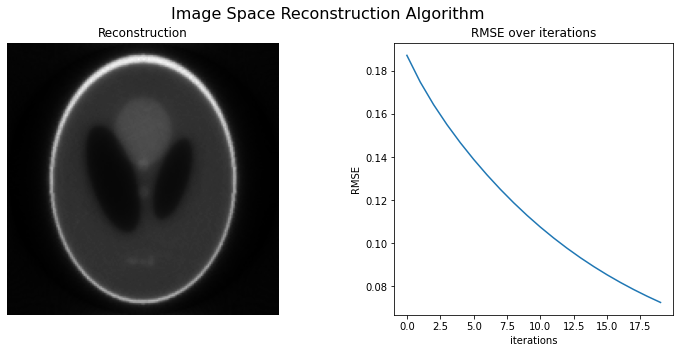

RMS for ISRA reconstruction with 20 iterations is 0.0726


In [56]:
fig = plt.figure(figsize=(12, 5))
fig.tight_layout()
fig.suptitle('Image Space Reconstruction Algorithm', fontsize=16)
grid = plt.GridSpec(1, 2, wspace=0.4, hspace=0.3)

recostr_isra = fig.add_subplot(grid[0, 0])
recostr_isra.imshow(r_isra)
recostr_isra.set_axis_off()
recostr_isra.set_title("Reconstruction")

ax_RMS = fig.add_subplot(grid[0, 1])
ax_RMS.plot(rms_isra)
ax_RMS.set_xlabel("iterations")
ax_RMS.set_ylabel("RMSE")
ax_RMS.set_title("RMSE over iterations")

plt.show()

rms_isra_20 = calculate_RMS(r_isra, Shepp_Logan)

print("RMS for ISRA reconstruction with 20 iterations is {:.4f}".format(rms_isra_20))

The algorithm is working as expected - the projection looks like the original Shepp Logan phantom and the RMSE is declining over time.  We could visualize the algorithm better using the `v_isra` function.

In [57]:
# v_isra("isra", Shepp_Logan, end_theta=END_THETA, iterations=100)

![](data/gif/isra.gif "Image Space Reconstruction Algorithm")

In order to see how many iterations are needed for convergence we will run the function for $1500$ iterations. Since this will take a lot of time the final state of the matrix will be saved locally.

In [58]:
# # This cell is comented due to long execution time. The resulting plots are saved localy 

# r_isra,rms_isra = isra(sinogram, iterations=1500,interpolate=False,RMS_image=Shepp_Logan)

In [59]:
# # This cell should be uncomented if the cell above is executed. 

# min_rms = np.min(rms_isra)
# min_rms_pos = np.where(rms_isra == min_rms)
# min_rms_pos = min_rms_pos[0][0]

# fig = plt.figure(figsize=(12, 5))
# fig.tight_layout()
# fig.suptitle('Image Space Reconstruction Algorithm', fontsize=16)
# grid = plt.GridSpec(1, 2, wspace=0.4, hspace=0.3)

# recostr_isra = fig.add_subplot(grid[0, 0])
# recostr_isra.imshow(r_isra)
# recostr_isra.set_axis_off()
# recostr_isra.set_title("Reconstruction")

# ax_RMS = fig.add_subplot(grid[0, 1])
# ax_RMS.plot(rms_isra)
# ax_RMS.axvline(min_rms_pos, c="red", alpha = 0.5, label="RMS min={:.3f}\nat {} iteration".format(min_rms,min_rms_pos))
# ax_RMS.set_xlabel("iterations")
# ax_RMS.set_ylabel("RMSE")
# ax_RMS.set_title("RMSE over iterations")
# ax_RMS.legend()

# plt.show()

![](data/saved_plots/ISRA_conv.png)

As you can see ISRA as well as SART reaches convergence after many iterations converges after many iterations. We will assume as well that the algorithm has reached convergence at 1500 iterations.


Now let's save the state of the reconstruction.

In [60]:
# This cell is comented due to long execution time. The results are saved localy


# np.save('data/save_states/r_isra_1500.npy', r_isra)
# np.save('data/save_states/rms_isra.npy', rms_isra)

In [61]:
# If the cell above is not executed the the results of the execution should be loaded

r_isra_1500 = np.load('data/save_states/r_isra_1500.npy')
rms_isra = np.load('data/save_states/rms_isra.npy')

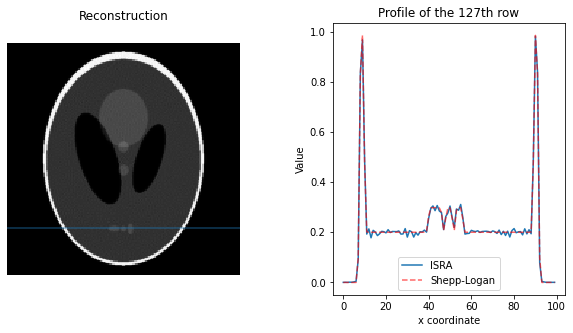

In [62]:
fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(1, 2, wspace=0.4, hspace=0.3)

recostr_sart = fig.add_subplot(grid[0, 0])
recostr_sart.matshow(r_isra_1500)
recostr_sart.set_axis_off()
recostr_sart.axhline(127, alpha=0.5)
recostr_sart.set_title("Reconstruction")

ax_line = fig.add_subplot(grid[0, 1])
ax_line.plot(r_isra_1500[127, 30:130], label="ISRA")
ax_line.plot(ref_line, "--", c="r", label="Shepp-Logan", alpha=0.6)
ax_line.set_xlabel("x coordinate")
ax_line.set_ylabel("Value")
ax_line.legend()
ax_line.set_title("Profile of the 127th row")
plt.show()

As you can see the reconstruction is nearly perfect and the tree hematoma tumors can be destinguished as good as in the original image. This should be shown as well in the RMS value

In [63]:
rms_isra_1500 = calculate_RMS(r_isra_1500, Shepp_Logan)

print("RMS for ISRA reconstruction with 1500 iterations is {:.4f}".format(rms_isra_1500))

RMS for ISRA reconstruction with 1500 iterations is 0.0061


## Comparison and results

The most important thing to keep in mind when comparing the results is that the aim of this notebook is not to write an optimized version of the reconstruction techniques, but rather showcase their algorithms. On all of the algorithms some adjustments could be made to improve their speed and their spacial resolution. 

That said a big distinction is to be made between analytic and iterative reconstruction methods. The first methods to emerge and to be used (until recently) were the analytic ones. They offer good reconstructions with low technical requirements, but the results are often not so accurate and are very sensible to noise(which comes from the imaging systems). With the advance of the computers, dedicated hardware and optimization of the algorithms in recent years the iterative algorithms are much more preferred because of their lower sensitivity to noise and reduced patient dose. However these reconstructions are still slower than the algebraic ones and there are still cases where the latter ones are preferred (e.g. in medical cases where time is essential).

That being said we can make a table of the RMS values for the different algorithms

| Algorithm                                                 | RMS value |
|:----------------------------------------------------------|:----------|
| Back projection                                           | N/A       |
| CST reconstruction without interpolation                  | 0.146     |
| CST reconstruction with linear interpolation              | 0.094     |
| CST reconstruction with cubic interpolation               | 0.059     |
| CST reconstruction with cubic interpolation  with padding | 0.032     |
| SART - 20 iterations                                      | 0.0951    |
| ISRA - 20 iterations                                      | 0.0726    |
| SART - 1500 iterations                                    | 0.0056    |
| ISRA - 1500 iterations                                    | 0.0061    |

As is to be expected the RMSE of the iterative methods with high number of iterations is much smaller than the analytic ones. When looking at $20$ iterations the results are comparable. This result is quite interesting since it tells us that it is better to use the much more faster and less hardware dependent analytical method if we do not have the resources(e.g. time, hardware) to make to make more than a few iterations with an iterative method.

Another thing we see is that the ISRA and SART have a noticeable difference in their 20th iteration. We could plot how the RMS converges for the two algorithms.

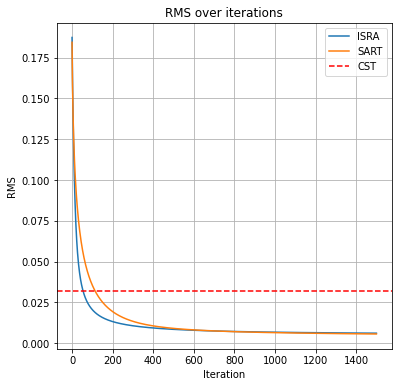

In [64]:
plt.plot(rms_isra, label="ISRA")
plt.plot(rms_sart, label="SART")
plt.axhline(rms_CST_cub_pad, label="CST", ls='--', c="red")
plt.title("RMS over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMS")
plt.grid()
plt.legend()
plt.show()

We can notice that the ISRA algorithm converges faster than the SART algorithm, but after the $600$th iteration the RMS values are similar. It is very important to note that while we can compare the number of iteration we can not compare the time for one iteration since the algorithms in this notebook are not optimized for speed but rather readability.

In the chart I have also added the value of the RMS of the central slice theorem reconstruction with cubic interpolation and padding. It can be seen that only after around $50$ iterations for ISRA and $150$ for SART they are preforming better than the analytical algorithm.

Now let's compare some of the line profiles.

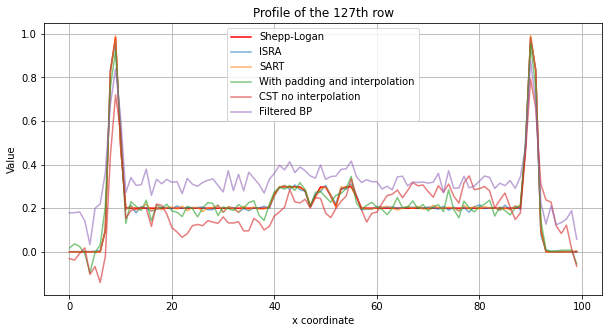

In [65]:
plt.rcParams["figure.figsize"] = (10, 5)

plt.plot(ref_line, c="r", label="Shepp-Logan")
plt.plot(r_isra_1500[127, 30:130], label="ISRA", alpha=0.6)
plt.plot(r_sart_1500[127, 30:130], label="SART", alpha=0.6)
plt.plot(CST_recon_pad[127, 30:130], label="With padding and interpolation", alpha=0.6)
plt.plot(CST_recon[127, 30:130], label="CST no interpolation", alpha=0.6)
plt.plot(filt_reconstruction[127, 30:130], label="Filtered BP", alpha=0.6)
plt.xlabel("x coordinate")
plt.ylabel("Value")
plt.title("Profile of the 127th row")
plt.grid()
plt.legend()
plt.show()

This chart shows that the most of the algorithms manage to distinguish the three hematoma with variable success. The iterative algorithms, although slow, are having much better results in comparison to the analytical ones.

In conclusion I would like to say that there are multiple methods for image reconstruction with different tradeoffs between speed, spatial resolution, sensitivity to noise and dose that the patient receives. That is why it is very important to have a basic knowledge of the workings of the algorithms and their tradeoffs in order to use a suitable one for a given task.

## Literature

* Used images
    * [Radon transform diagram from MATLAB online documentation](https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/AV0405/HAYDEN/Slice_Reconstruction.html)
    * [Mohammed H. Ali Al-Hayani](https://www.researchgate.net/figure/Shepp-Logan-head-phantom-image-The-2D-Shepp-Logan-phantom-image-illustrates-many-of-the_fig5_337495686)
    * [snmjournals.org](https://jnm.snmjournals.org/content/42/10/1499/tab-figures-data )
    * [pysdr.org](https://pysdr.org/content/frequency_domain.html)
    * [Maier Andreas](https://www5.cs.fau.de/fileadmin/persons/MaierAndreas/maier/Hornegger16-CRB.pdf)
* Literature
    * [*The evolution of image reconstruction for CT—from filtered back projection to artificial intelligence*, Martin J. Willemink, Peter B. Noël](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6443602/)
    * [*On the determination of functions from their integral values along certain manifolds*, Radon, Johann](https://ieeexplore.ieee.org/document/4307775)
    * [radiologykey](https://radiologykey.com/tomographic-reconstruction-in-nuclear-medicine/)
    * [wikipedia - Algebraic reconstruction technique](https://en.wikipedia.org/wiki/Algebraic_reconstruction_technique)
    * [*SIMULTANEOUS ALGEBRAIC RECONSTRUCTION TECHNIQUE (SART):A SUPERIOR IMPLEMENTATION OF THE ART ALGORITHM*, A. H. Andersen and A. C. Kak](https://engineering.purdue.edu/RVL/Publications/SART_84.pdf)
    * [*Principles of Computerized Tomographic Imaging*, Avinash C. Kak - Chapter 7](https://engineering.purdue.edu/~malcolm/pct/CTI_Ch07.pdf)
    * [*An Iterative Image Space Reconstruction Algorthm Suitable for Volume ECT*, M E Daube-Witherspoon, G Muehllehner](https://pubmed.ncbi.nlm.nih.gov/18243988/)
    * [*Filter-based reconstruction methods for tomography*, Daniël Maria Pelt](https://ir.cwi.nl/pub/24652/24652D.pdf)
    * 3D Image Reconstruction for CT and PET*, Dr. Daniele Panetta, Dr. Niccol\`o Camarlinghi
    * [Andrew J. Reader](https://www.youtube.com/user/andrewjreader)
    * [wikipedia - Tomographic reconstruction](https://en.wikipedia.org/wiki/Tomographic_reconstruction)
    * [wikipedia - Radon transform](https://en.wikipedia.org/wiki/Radon_transform)
* Other
    * [Mateen Ulhaq](https://stackoverflow.com/questions/32166879/do-i-need-to-call-fftshift-before-calling-fft-or-ifft)
    * [csheaf](https://github.com/csheaff/filt-back-proj/tree/633687a4a81cb306a55570752b6b9e9eefaba2a6)
    * [*The Python Coding Book*, Stephen Gruppetta](https://thepythoncodingbook.com/2021/08/30/2d-fourier-transform-in-python-and-fourier-synthesis-of-images/)
    * [hanyoseob ](https://github.com/hanyoseob/python-ART)
    * [crazybiocomputing](https://crazybiocomputing.blogspot.com/2013/01/learning-tomography-fourier-rec-part-ii.html?m=1)
    * [timday](https://dsp.stackexchange.com/questions/3576/whats-wrong-with-this-code-for-tomographic-reconstruction-by-the-fourier-method)
    * [wikipedia - Kaczmarz method](https://en.wikipedia.org/wiki/Kaczmarz_method)
    * [*The Radon Transform: Basic Principle*, Peter Barrett Bryan](https://towardsdatascience.com/the-radon-transform-basic-principle-3179b33f773a)